In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [92]:
!pip install stable-baselines3 protobuf==3.20.*
!pip install gymnasium

In [6]:
!pip install mss pydirectinput pytesseract

In [16]:
!pip install opencv-python gym

     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
      --------------------------------------- 10.2/721.7 kB ? eta -:--:--
     --- --------------------------------- 71.7/721.7 kB 787.7 kB/s eta 0:00:01
     --------------------- ---------------- 409.6/721.7 kB 3.2 MB/s eta 0:00:01
     -------------------------------------- 721.7/721.7 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827634 sha256=5761a7a7173ea72570c64f541f86e8d523327fa68cd63d4e28809cdb17b5d0f7
  Stored in directory: c:\users

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
# 2.1. Build environment

In [2]:
class WebGame(Env):
    # setup the vn action and observation shapes

    metadata = {"render_modes": ["human"], "render_fps": 30}
    def __init__(self):
        # Subclass model
        super().__init__()
        # Setp spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top':400, 'left':0, 'width':600, 'height':500}
        self.done_location = {'top':440, 'left':630, 'width':660, 'height':70}
        
        
    # What is called to do something in the game
    def step(self, action):
        # Action ket: 0 = Jump, 1 = Duck, 2 = No action (no op)
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        if action != 2:
            pydirectinput.press(action_map[action])

        # Checking whether the game is done
        done, done_cap = self.get_done()
        # Get the next observation
        new_observation = self.get_observation()
        # Reward - get a point for every frame alive
        reward = 1
        # terminated added, required
        terminated = reward == 0
        # info dictionary, stable_baselines required, not used by us
        info = {"is_success": terminated}

        return new_observation, reward, terminated, done, info
        
    # Visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

        

    # This closes down the observation
    def close(self):
        cv2.destroyAllWindows()


    # Restart the game
    # def reset(self, seed = None):
    def reset(self, seed = None):
        super().reset(seed = seed)
        time.sleep(1)
        pydirectinput.click(x=250, y=250)
        pydirectinput.press('space')
        # info dictionary, stable_baselines required, not used by us
        info = {}
        
        return self.get_observation(), info

 
    # Get the part of the observation of the game that we want (seeing the game screen)
    def get_observation(self):
        # get screen capture of the game
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]
        # grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (100, 83))
        # Add channels first (stable baseline requires it this way, channels first)
        channel = np.reshape(resized, (1, 83, 100))
        return channel

    # Get the done text using OCR
    def get_done(self):
        # get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        # valid done text
        done_strings = ['GAME', 'GAHE']

        # Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True

        return done, done_cap


In [3]:
env = WebGame()

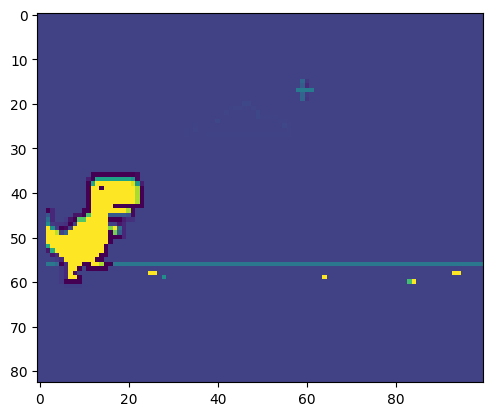

In [5]:
plt.imshow(env.get_observation()[0])

In [9]:
done, done_cap = env.get_done()

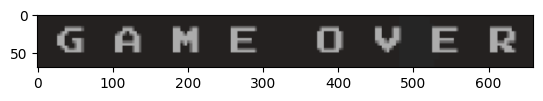

In [10]:
plt.imshow(done_cap)

In [11]:
# Test loop

In [12]:
for episode in range(2):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        obs, reward, terminated, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total reward for episode {episode} is {total_reward}')

Total reward for episode 0 is 25


KeyboardInterrupt: 

In [39]:
# 3. Train the model

In [13]:
# Import os for file path managment
import os
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Invironment
from stable_baselines3.common import env_checker

In [9]:
env_checker.check_env(env)

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [16]:
callback = TrainAndLoggingCallback(check_freq=300, save_path=CHECKPOINT_DIR)

In [13]:
# BUILD AND TRAIN 

In [17]:
# import DQN algo
from stable_baselines3 import DQN

In [15]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
            buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [16]:
# Kick off training
model.learn(total_timesteps=88000, callback=callback)

Logging to ./logs/DQN_8
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.2     |
|    ep_rew_mean      | 15.2     |
|    exploration_rate | 0.993    |
|    success_rate     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 27       |
|    total_timesteps  | 61       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.6     |
|    ep_rew_mean      | 15.6     |
|    exploration_rate | 0.987    |
|    success_rate     | 0        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 53       |
|    total_timesteps  | 125      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.9     |
|    ep_rew_mean      | 15.9   

In [22]:
# Load saved model
# model.load(os.path.join('train_first', 'best_model_88000'))
model = DQN.load(os.path.join('train', 'best_model_54900'))

In [23]:
for episode in range(3):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, terminated, done, info = env.step(int(action))
        # time.sleep(0.01)
        total_reward += reward
    print(f'Total reward for episode {episode} is {total_reward}')
    # time.sleep(2)

Total reward for episode 0 is 33
Total reward for episode 1 is 60
Total reward for episode 2 is 58


In [24]:
#tensorboard
training_log_path = os.path.join('./logs/', 'DQN_8')

In [30]:
!tensorboard --logdir=[training_log_path]

^C


In [31]:
training_log_path

'./logs/DQN_8'